## Supplement 2. find change of mind trials where the animal turned around rather than backed up.

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import spyglass as nd
import pandas as pd
import numpy as np
import xarray as xr
from scipy import stats
from scipy import linalg
import os
import pickle
import matplotlib.pyplot as plt
from ripple_detection.core import segment_boolean_series

from spyglass.common import (Session, IntervalList,LabMember, LabTeam, Raw, Session, Nwbfile,
                            Electrode,LFPBand,interval_list_intersect)
from spyglass.common import TaskEpoch
from spyglass.spikesorting.v0 import (SortGroup, 
                                    SpikeSortingRecording,SpikeSortingRecordingSelection)
from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename
from spyglass.common.common_position import IntervalPositionInfo, RawPosition, IntervalLinearizedPosition, TrackGraph

[2025-02-25 21:10:25,249][INFO]: Connecting shijiegu-alt@lmf-db.cin.ucsf.edu:3306
[2025-02-25 21:10:25,307][INFO]: Connected shijiegu-alt@lmf-db.cin.ucsf.edu:3306


In [3]:
from spyglass.shijiegu.load import load_run_sessions, load_decode, load_theta_maze
from spyglass.shijiegu.Analysis_SGU import TrialChoice,EpochPos,MUA,get_linearization_map, TrialChoiceChangeOfMind, DecodeResultsLinear
from spyglass.shijiegu.decodeHelpers import runSessionNames
from spyglass.shijiegu.ripple_add_replay import plot_decode_spiking
from spyglass.shijiegu.changeOfMind import (insertTrialChoiceChangeOfMind, find_turnaround_time, findProportion,
            find_trials, load_epoch_data_wrapper, find_direction, find_trials_animal, unique_stable)
from spyglass.shijiegu.helpers import interpolate_to_new_time

from spyglass.shijiegu.theta import return_skaggs_theta
import matplotlib.patheffects as PathEffects
from spyglass.spikesorting.v0 import Curation
from spyglass.shijiegu.singleUnit import get_nwb_units, electrode_unit 
from spyglass.shijiegu.ripple_add_replay import select_subset_helper,select_subset_helper_pd

[21:10:35][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.
[21:10:35][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


In [4]:
linear_map,node_location=get_linearization_map()

[21:10:35][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


In [85]:
nwb_copy_file_name = "lewis20240121_.nwb"
session_interval, position_interval = runSessionNames(nwb_copy_file_name)
print(session_interval)

['02_Rev1Session1', '04_Rev1Session2', '06_Rev1Session3', '08_Rev1Session4']


In [7]:
epoch_ind = 0
session_name = session_interval[epoch_ind]
position_name = position_interval[epoch_ind]

In [8]:
log_df = pd.read_pickle( (TrialChoiceChangeOfMind() & {"nwb_file_name": nwb_copy_file_name,
                                                           "epoch":int(session_name[:2])}).fetch1("change_of_mind_info") )
    

In [12]:
log_df[50:]

,timestamp_H,Home,timestamp_O,OuterWellIndex,rewardNum,change_of_mind,CoMMaxProportion,CoM_t,CoM_arm,current,future_H,future_O,past,past_reward
51,1.705780e+09,1.0,1.705780e+09,1.0,2.0,False,[],[],[],1.0,1.0,2.0,3.0,3.0
52,1.705780e+09,1.0,1.705780e+09,2.0,1.0,False,[],[],[],2.0,2.0,4.0,1.0,1.0
53,1.705780e+09,1.0,1.705780e+09,4.0,2.0,False,[],[],[],4.0,4.0,3.0,2.0,1.0
54,1.705780e+09,1.0,1.705781e+09,3.0,1.0,False,[],[],[],3.0,3.0,4.0,4.0,4.0
55,1.705781e+09,1.0,1.705781e+09,4.0,1.0,True,0.430346,"[[1705780519.6546037, 1705780520.5546038]]","[[1, 4, -9223372036854775808]]",4.0,4.0,2.0,3.0,4.0
56,1.705781e+09,1.0,1.705781e+09,2.0,2.0,False,[],[],[],2.0,2.0,1.0,4.0,4.0
57,1.705781e+09,1.0,1.705781e+09,1.0,1.0,False,[],[],[],1.0,1.0,3.0,2.0,2.0
58,1.705781e+09,1.0,1.705781e+09,3.0,2.0,False,[],[],[],3.0,3.0,4.0,1.0,2.0
59,1.705781e+09,1.0,1.705781e+09,4.0,1.0,False,[],[],[],4.0,4.0,2.0,3.0,3.0
60,1.705781e+09,1.0,1.705781e+09,2.0,1.0,False,[],[],[],2.0,2.0,1.0,4.0,3.0


In [14]:
log_df.loc[55,"CoM_t"][0]

[1705780519.6546037, 1705780520.5546038]

In [180]:
def find_nonbackout_session(nwb_copy_file_name, session_name, position_name):
    """
    This function is very similar to find_backout_session(),
    except it finds change of mind trials that the rats have successfully turned around within 1 sec after stopping
    """
    log_df = pd.read_pickle( (TrialChoiceChangeOfMind() & {"nwb_file_name": nwb_copy_file_name,
                                                           "epoch":int(session_name[:2])}).fetch1("change_of_mind_info") )
    
    linear_position_info=(IntervalLinearizedPosition() & {
            'nwb_file_name':nwb_copy_file_name,
            'interval_list_name':position_name,
            'position_info_param_name':'default_decoding'}).fetch1_dataframe()
    
    position_info = (IntervalPositionInfo() & {
            'nwb_file_name':nwb_copy_file_name,
            'interval_list_name':position_name,
            'position_info_param_name':'default_decoding'}).fetch1_dataframe()
    
    backout_segments_session = []
    for t in log_df.index[:-2]:
        
        start = log_df.loc[t,'timestamp_O']
        end = log_df.loc[t+1,'timestamp_H']
        if np.isnan(start) or np.isnan(end):
            continue
        if not log_df.loc[t,'change_of_mind']:
            continue
        change_times = log_df.loc[t,'CoM_t'][0] # 0 index is just because results are always saved in a single list
        print("change_times",change_times)

        for change_time_ind in range(len(change_times)):
            start = change_times[change_time_ind]
            end = start + 1
    
            trialInd = (linear_position_info.index >= start) & (linear_position_info.index <= end)
            trialInfo = linear_position_info.loc[trialInd]
            trialInfo2D = position_info.loc[trialInd]
            outerArmInd = trialInfo.track_segment_id >= 6
            trialInfo = trialInfo.loc[outerArmInd,:]
            trialInfo2D = trialInfo2D.loc[outerArmInd,:]
        
            arm_direction_t, arm_direction, all_arms_direction = find_direction(trialInfo, trialInfo2D)
            #head_direction_sign = pd.Series(arm_direction, index = arm_direction_t)
    
            trialInfo1D = interpolate_to_new_time(trialInfo, arm_direction_t)
            if len(arm_direction_t) == 0:
                continue
            movement_direction_sign = np.concatenate([[0],np.diff(trialInfo1D.linear_position)])
    
            nonbackoff = np.logical_and(arm_direction < 0,movement_direction_sign < 0) #* movement_direction_sign) > 0
            
            
            # animal needs to be at least 10 cm away from reward well
            well_id = np.array(trialInfo1D.track_segment_id)[0] - 5
            print('trial '+str(t),'well_id',str(well_id))
            if well_id < 1:
                continue
        
            outer_well_linear = node_location['well'+str(well_id)]
            #nonbackoff = nonbackoff * np.abs(trialInfo1D.linear_position - outer_well_linear) >= 20
        
            backoff_pd = pd.Series(nonbackoff, index = arm_direction_t)
    
            backout_segments = np.array(segment_boolean_series(
                backoff_pd, minimum_duration=0.3)).reshape((-1,2))
            if len(backout_segments) > 0:
                for backout_segment in backout_segments:
                    trialInfo1D_segment = interpolate_to_new_time(trialInfo, backout_segment)
                    if np.abs(np.array(trialInfo1D_segment.linear_position)[0] - outer_well_linear) < 10:
                        continue
                    #if np.abs(np.diff(np.array(trialInfo1D_segment.linear_position))) < 10:
                    #    continue
                
                    backout_segments_session.append(([nwb_copy_file_name, session_name, position_name, t],backout_segment))
    return backout_segments_session #, head_direction_sign

In [169]:
animal = 'Eliot'
dates_to_plot = ['20221017','20221018','20221019','20221020','20221021','20221022','20221023','20221024','20221025','20221026']

In [46]:
animal = 'Lewis'
dates_to_plot = ['20240102','20240103','20240104','20240105','20240106','20240107','20240108','20240109',
                 '20240110','20240113','20240114','20240115','20240116','20240117','20240118','20240119','20240120']

In [47]:
animal = 'Haydn'
dates_to_plot = ['20230603','20230604','20230605','20230606','20230607','20230608']

### 1. Load non-change-of-mind

In [404]:
nwb_copy_file_name = "haydn20230608_.nwb"

In [405]:
session_interval, position_interval = runSessionNames(nwb_copy_file_name)
print(session_interval)

['02_Rev3Session1', '04_Rev3Session2', '06_Rev3Session3', '08_Rev3Session4', '10_Rev3Session5']


In [406]:
nonbackout_segments_day = []
for epoch_ind in range(len(session_interval)):
    session_name = session_interval[epoch_ind]
    position_name = position_interval[epoch_ind]
    
    nonbackout_segments_session = find_nonbackout_session(nwb_copy_file_name, session_name, position_name)
    if len(nonbackout_segments_session) > 0:
        for b in nonbackout_segments_session:
            nonbackout_segments_day.append(b)
    

[22:28:17][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.
[22:28:21][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


change_times [1686245704.6964781]
trial 19 well_id 3
change_times []
change_times [1686246839.8799152, 1686246844.277913, 1686246845.7839124]
trial 57 well_id 2
trial 57 well_id 1
trial 57 well_id 1
change_times [1686247259.4997072]
trial 74 well_id 2
change_times [1686247306.9416838]
trial 76 well_id 4
change_times [1686247387.099644]
trial 78 well_id 2
change_times [1686247421.521627]
trial 79 well_id 2


[22:28:23][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


change_times [1686250010.1386049, 1686250014.666602, 1686250015.6906013, 1686250016.4186008, 1686250018.7245994, 1686250020.814598, 1686250021.4985976, 1686250023.0345967, 1686250024.6145957]
trial 1 well_id 4
trial 1 well_id 4
trial 1 well_id 4
trial 1 well_id 4
trial 1 well_id 4
trial 1 well_id 4
trial 1 well_id 4
trial 1 well_id 4
trial 1 well_id 4
change_times [1686250592.596232]
trial 23 well_id 1
change_times [1686250754.872128]
trial 30 well_id 2
change_times []
change_times [1686251011.7839634]
trial 42 well_id 2
change_times [1686251032.71195, 1686251033.6059494, 1686251035.3279483]
trial 43 well_id 2
trial 43 well_id 2
trial 43 well_id 2
change_times [1686251298.5077798]
trial 54 well_id 4
change_times [1686251392.3717196]
trial 57 well_id 2
change_times [1686251965.6453526]
trial 79 well_id 2


[22:28:25][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


change_times [1686255739.3813825]
trial 12 well_id 2
change_times [1686255842.5153735]
trial 16 well_id 2
change_times [1686255992.0673604, 1686255993.0913603]
trial 22 well_id 1
trial 22 well_id 1
change_times [1686256069.5333538]
trial 25 well_id 2
change_times [1686256206.9173417]
trial 31 well_id 3
change_times [1686256243.5993385]
trial 33 well_id 1
change_times [1686256267.1713367]
trial 34 well_id 2
change_times [1686256542.8333127, 1686256546.1213124]
trial 47 well_id 2
trial 47 well_id 1
change_times [1686256729.3252964]
trial 55 well_id 2
change_times [1686256829.9192877]
trial 59 well_id 3
change_times [1686256865.8532846, 1686256869.9112842]
trial 60 well_id 2
trial 60 well_id 2
change_times [1686256900.9992816]
trial 61 well_id 1
change_times [1686257380.53524]
trial 80 well_id 1


[22:28:26][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


change_times [1686259930.0843427]
trial 6 well_id 2
change_times [1686260048.8903322]
trial 11 well_id 2
change_times [1686260102.7403276]
trial 13 well_id 1
change_times [1686260150.2703233]
trial 14 well_id 2
change_times [1686260278.598312]
trial 20 well_id 4
change_times [1686260458.166296, 1686260463.4262955]
trial 28 well_id 1
trial 28 well_id 3
change_times [1686260535.3002892]
trial 31 well_id 2
change_times [1686260614.602282]
trial 34 well_id 2
change_times [1686260734.5622716]
trial 39 well_id 2
change_times [1686260812.1122646]
trial 42 well_id 2
change_times [1686260940.3982532, 1686260942.236253]
trial 47 well_id 3
trial 47 well_id 2
change_times [1686261040.8842444]
trial 51 well_id 2
change_times [1686261115.4042377, 1686261119.6722374]
trial 55 well_id 1
trial 55 well_id 4
change_times [1686261176.5982323]
trial 57 well_id 2
change_times [1686261555.5201988]
trial 73 well_id 3
change_times [1686261586.612196]
trial 74 well_id 2
change_times [1686264300.958628, 16862643

In [407]:
nonbackout_segments_day

[(['haydn20230608_.nwb', '04_Rev3Session2', 'pos 3 valid times', 23],
  array([1.68625059e+09, 1.68625059e+09])),
 (['haydn20230608_.nwb', '06_Rev3Session3', 'pos 5 valid times', 22],
  array([1.68625599e+09, 1.68625599e+09])),
 (['haydn20230608_.nwb', '08_Rev3Session4', 'pos 7 valid times', 6],
  array([1.68625993e+09, 1.68625993e+09])),
 (['haydn20230608_.nwb', '08_Rev3Session4', 'pos 7 valid times', 11],
  array([1.68626005e+09, 1.68626005e+09])),
 (['haydn20230608_.nwb', '08_Rev3Session4', 'pos 7 valid times', 13],
  array([1.6862601e+09, 1.6862601e+09])),
 (['haydn20230608_.nwb', '08_Rev3Session4', 'pos 7 valid times', 28],
  array([1.68626046e+09, 1.68626046e+09])),
 (['haydn20230608_.nwb', '10_Rev3Session5', 'pos 9 valid times', 1],
  array([1.68626431e+09, 1.68626431e+09])),
 (['haydn20230608_.nwb', '10_Rev3Session5', 'pos 9 valid times', 25],
  array([1.6862649e+09, 1.6862649e+09])),
 (['haydn20230608_.nwb', '10_Rev3Session5', 'pos 9 valid times', 53],
  array([1.68626551e+09,

In [385]:
decode_options = {}
decode_options["encoding_set"] = '2Dheadspeed_above_4' #'2Dheadspeed_above_4_andlowmua'#'2Dheadspeed_above_4'
decode_options["classifier_param_name"] = 'default_decoding_gpu_4armMaze'
decode_options["decode_threshold_method"] = 'MUA_0SD'
decode_options["causal"] = False
decode_options["likelihood"] = False

In [462]:
bi = 9
backout_segment = nonbackout_segments_day[bi]
plottimes = (backout_segment[1][0]-2, backout_segment[1][1]+3)
(nwb_copy_file_name, session_name, position_name, t) = nonbackout_segments_day[bi][0]
print(plottimes)
print(nwb_copy_file_name, session_name, position_name, 'trial '+str(t))

IndexError: list index out of range

In [457]:
log_df = pd.read_pickle( (TrialChoiceChangeOfMind() & {"nwb_file_name": nwb_copy_file_name,
                                                           "epoch":int(session_name[:2])}).fetch1("change_of_mind_info") )
    
linear_position_info=(IntervalLinearizedPosition() & {
            'nwb_file_name':nwb_copy_file_name,
            'interval_list_name':position_name,
            'position_info_param_name':'default_decoding'}).fetch1_dataframe()
    
position_info = (IntervalPositionInfo() & {
            'nwb_file_name':nwb_copy_file_name,
            'interval_list_name':position_name,
            'position_info_param_name':'default_decoding'}).fetch1_dataframe()

# 3. load decode
decode = load_decode(nwb_copy_file_name,session_name,
                     decode_options["classifier_param_name"],decode_options["encoding_set"])
# 4. load spikes
curation_id = 1
from spyglass.shijiegu.singleUnit_sortedDecode import place_field_direction, color_cells_by_place_direction

(cells, smoothed_placefield, placefield_peak,
        spike_count_by_arm_direction, time_spent_by_arm_direction, betaPdfs, means) = place_field_direction(nwb_copy_file_name,
                                                                                session_name,position_name,
                                                                                curation_id = curation_id)
cell_color = color_cells_by_place_direction(cells, placefield_peak, spike_count_by_arm_direction)

sort_group_ids = np.unique((Curation() & {'nwb_file_name': nwb_copy_file_name,
                                              "curation_id":1}).fetch("sort_group_id"))

nwb_units_all = get_nwb_units(
            nwb_copy_file_name,session_name,sort_group_ids,curation_id = curation_id)

[22:35:19][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.
[22:35:19][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


In [458]:
log_df.loc[t]

timestamp_H                       1686265503.01456
Home                                           1.0
timestamp_O                      1686265518.864572
OuterWellIndex                                 3.0
rewardNum                                      2.0
change_of_mind                                True
CoMMaxProportion                               1.0
CoM_t                        [[1686265513.674576]]
CoM_arm             [[1, 3, -9223372036854775808]]
current                                        3.0
future_H                                       3.0
future_O                                       2.0
past                                           2.0
past_reward                                    4.0
Name: 53, dtype: object

In [459]:
import scipy.signal as ss
#theta_df, pos1d, pos2d = return_skaggs_theta(nwb_copy_file_name,position_name,session_name,
#                                             nwb_units_all,cells)
#theta_df.index.name='time'
#theta_df=xr.Dataset.from_dataframe(theta_df)

theta_xr = load_theta_maze(nwb_copy_file_name,session_name)
theta_xr = theta_xr.assign(phase0=('time',np.angle(ss.hilbert(theta_xr[0]))))
#theta_xr = theta_xr.assign(phase1=('time',np.angle(ss.hilbert(theta_xr[1]))))
theta_df = theta_xr.to_dataframe()

In [460]:
results_subset = select_subset_helper(decode,plottimes)
#head_direction_sign_subset = select_subset_helper_pd(head_direction_sign,plottimes)
#theta_xr_subset = select_subset_helper(theta_xr,plottimes)
#theta_df = theta_xr_subset.to_dataframe()

posterior_position_subset=results_subset.causal_posterior.sum(
        dim='state')
theta_subset = select_subset_helper(theta_xr,plottimes) 
theta_subset = theta_subset.to_dataframe()

linear_position_xr=xr.Dataset.from_dataframe(linear_position_info)
linear_position_subset= select_subset_helper(linear_position_xr,plottimes)


cells_fired = []
"""
for cell in cells:
    (e,u) = cell
    nwb_units = electrode_unit(nwb_copy_file_name,session_name,e,curation_id = curation_id)
    spike_times = nwb_units.loc[u].spike_times
    spike_times = spike_times[np.logical_and(spike_times >= plottimes[0],spike_times <= plottimes[1])]
    if len(spike_times) > 0:
        cells_fired.append(cell)
"""

'\nfor cell in cells:\n    (e,u) = cell\n    nwb_units = electrode_unit(nwb_copy_file_name,session_name,e,curation_id = curation_id)\n    spike_times = nwb_units.loc[u].spike_times\n    spike_times = spike_times[np.logical_and(spike_times >= plottimes[0],spike_times <= plottimes[1])]\n    if len(spike_times) > 0:\n        cells_fired.append(cell)\n'

Text(0.5, 1.0, 'speed')

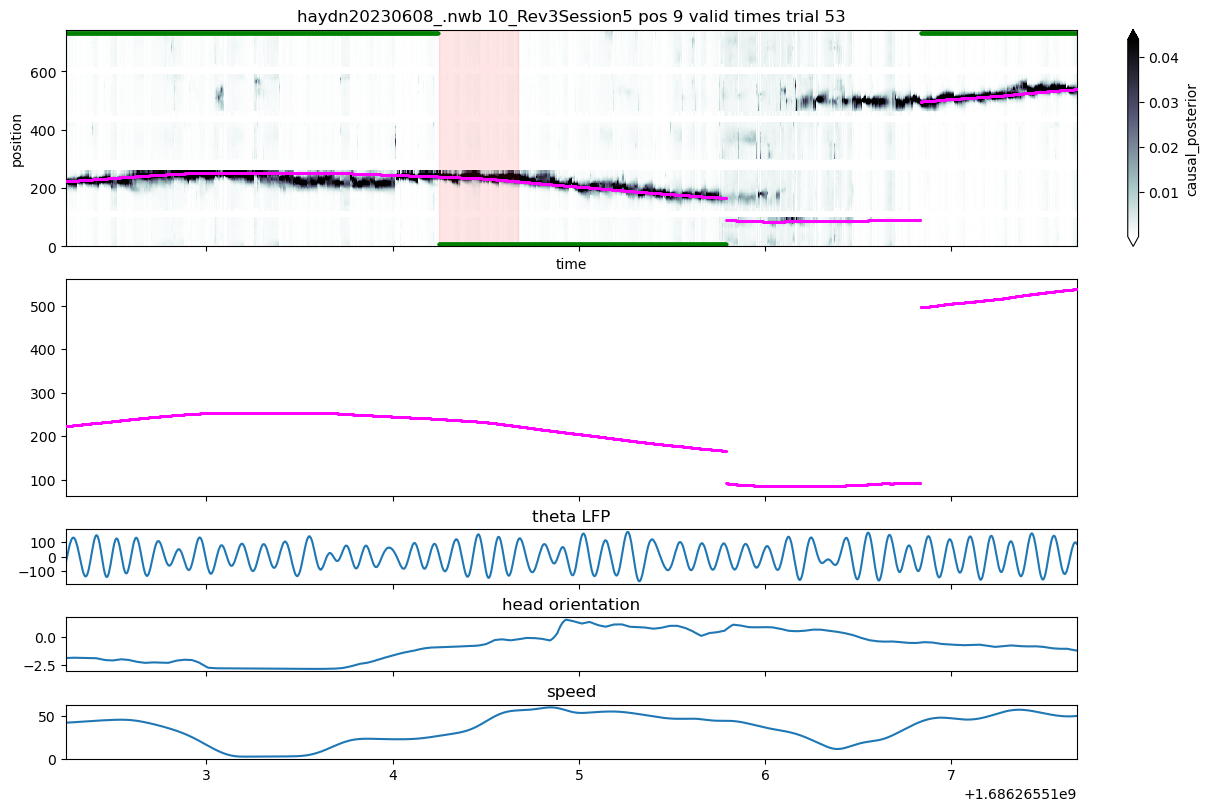

In [461]:
fig, axes = plt.subplots(5, 1, figsize=(12, 8), sharex=True,
                             constrained_layout=True,gridspec_kw={"height_ratios": [2,2,0.5,0.5,0.5]})
posterior_position_subset.plot(x='time', y='position', ax=axes[0], rasterized=True, robust=True, cmap='bone_r')
for cell in cells_fired:
    e = cell[0]
    u = cell[1]
    nwb_units = electrode_unit(nwb_copy_file_name,session_name,e,curation_id = curation_id)

    spike_times = nwb_units.loc[u].spike_times
    spike_times = spike_times[np.logical_and(spike_times >= plottimes[0],spike_times <= plottimes[1])]

    if cell_color[(e,u)] == "k":
        cell_color[(e,u)] = "C2"

    axes[1].scatter(spike_times, np.zeros(len(spike_times)) + placefield_peak[(e,u)],
                    rasterized=True, marker='|', color = cell_color[(e,u)],alpha = 0.5)
    if len(spike_times) > 0:
        txt = axes[1].text(spike_times[0],placefield_peak[(e,u)],str((e,u)),rotation = 10, color = cell_color[(e,u)])
        txt.set_path_effects([PathEffects.withStroke(linewidth=1, foreground='w',alpha = 0.8)])

theta_d0=np.array(np.array(theta_subset[0])).astype('int32').T
#theta_d1=np.array(np.array(theta_subset[1])).astype('int32').T
theta_t=np.array(theta_subset.index)
axes[2].plot(theta_t,theta_d0)
#axes[2].plot(theta_t,theta_d1)
axes[2].set_title('theta LFP')


axes[0].scatter(linear_position_subset.time,
                np.array(linear_position_subset.linear_position),
                s=1, color='magenta', zorder=10)

axes[1].scatter(linear_position_subset.time,
                np.array(linear_position_subset.linear_position),
                s=1, color='magenta', zorder=10)
axes[0].axvspan(backout_segment[1][0], backout_segment[1][1], color = "red", alpha = 0.1)


trialInd = (linear_position_info.index >= plottimes[0]) & (linear_position_info.index <= plottimes[1])
trialInfo = linear_position_info.loc[trialInd]
trialInfo2D = position_info.loc[trialInd]
        
arm_direction_t, arm_direction, all_arms_direction = find_direction(trialInfo, trialInfo2D)
head_direction_sign = pd.Series(arm_direction, index = arm_direction_t)

axes[0].scatter(head_direction_sign.index,
        (head_direction_sign + 1) * 360 + 10, #so the top line is at 700
        s = 3, c = 'green')
axes[0].set_title(nwb_copy_file_name + ' ' + session_name + ' ' + position_name + ' ' + 'trial '+str(t))
axes[3].plot(trialInfo2D.index, trialInfo2D.head_orientation)
axes[3].set_title("head orientation")
axes[4].plot(trialInfo2D.index, trialInfo2D.head_speed)
axes[4].set_title("speed")